In [1]:
print("hello")

hello


In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python

In [7]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")



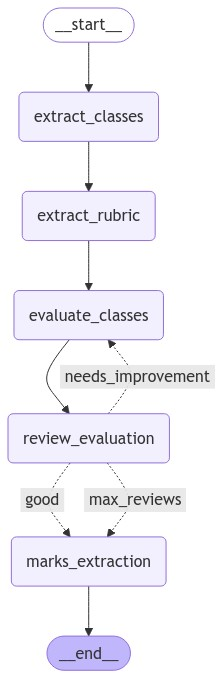

Evaluation Result:
Class Name: StringManipulator

Evaluation:
- Criterion: User Input
  Score: 2 out of 2
  Reasoning: The student correctly prompts the user to enter a string using a `Scanner` object. However, the model solution uses `sc.nextLine()` to read the entire line, while the student uses `sc.next()`, which only reads the next token. This could lead to issues if the user inputs a string with spaces. Despite this, the requirement to prompt for input is met.

- Criterion: String Operations
  Score: 2 out of 4
  Reasoning: 
  - The student displays the original string correctly.
  - The conversion to uppercase is incorrectly implemented using `input.toLowerCase()` instead of `input.toUpperCase()`, which does not meet the requirement.
  - The string reversal logic is flawed. The loop condition `i <= input.length()` causes an `IndexOutOfBoundsException` because it attempts to access an index equal to the length of the string. The model solution correctly uses `StringBuilder` to rev

KeyError: 'review_result'

In [54]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence, Dict, List
import re

# Define our state
class State(TypedDict):
    student_code: str
    model_solution: str
    extracted_classes: str
    full_rubric: str
    extracted_rubric: str
    evaluation_result: str
    review_count: int
    final_score: int

# Initialize the ChatOpenAI model
chat_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Class Extraction Node
java_class_extraction_template = """
You are a Java code analyzer. Your task is to extract all class definitions from the given Java code snippets.
First, analyze the student's code:
{student_code}
Extract all classes from the student's code and store them in a list called 'student_classes'.
Next, analyze the model solution:
{model_solution}
Extract all classes from the model solution and store them in a list called 'model_classes'.
Please provide your response in the following format:
Student Classes:
[List of full class definitions from student code]
Model Solution Classes:
[List of full class definitions from model solution]
Make sure to include all classes, including nested and inner classes if present. Provide the full class definition including all methods and fields.
"""

java_class_extraction_prompt = PromptTemplate(
    input_variables=["student_code", "model_solution"],
    template=java_class_extraction_template
)

def extract_classes(state: State) -> State:
    formatted_prompt = java_class_extraction_prompt.format(
        student_code=state['student_code'],
        model_solution=state['model_solution']
    )
    message = HumanMessage(content=formatted_prompt)
    response = chat_model.invoke([message])
    state['extracted_classes'] = response.content
    return state

# Rubric Extraction Node
rubric_extraction_template = """
You are a Java code analyzer. Your task is to extract the relevant rubric details that apply to the given Java classes from the student solution. Do not perform any evaluation or scoring.

Here is the content from the previous extraction step:

{extraction_content}

In this content, there should be a student solution and a model solution. Please identify the student solution and focus on extracting rubric details for the student's classes only.

Here is the full rubric:

{full_rubric}

For each class in the student's solution, please:
1. Identify the class name.
2. Extract only the relevant parts of the rubric that apply to this specific class.

Present your analysis in the following format for each student class:

Class Name: [Student Class Name]

Relevant Rubric Details:
[List only the relevant sections and subsections of the rubric that apply to this class, including the point values but without any evaluation]

If there are multiple classes in the student's solution, repeat this format for each class.

Remember:
- Do not provide any evaluation or scoring.
- Only extract the relevant rubric details for each student class.
- Include all relevant details, even if they seem to overlap between classes.
- Ignore the model solution for this task; focus only on the student's classes.
"""

rubric_extraction_prompt = PromptTemplate(
    input_variables=["extraction_content", "full_rubric"],
    template=rubric_extraction_template
)

def extract_rubric(state: State) -> State:
    formatted_prompt = rubric_extraction_prompt.format(
        extraction_content=state['extracted_classes'],
        full_rubric=state['full_rubric']
    )
    message = HumanMessage(content=formatted_prompt)
    response = chat_model.invoke([message])
    state['extracted_rubric'] = response.content
    return state

# Evaluation Node
evaluation_template = """
You are a Java code evaluator. Your task is to evaluate the student's Java classes based on the extracted rubric details and compare them with the model solution classes.

Here are the extracted classes:
{extracted_classes}

Here are the relevant rubric details for the student's classes:
{extracted_rubric}

Please evaluate each student class based on the rubric details and compare it with the corresponding model solution class. Provide a detailed evaluation for each criterion in the rubric, assigning scores and explaining your reasoning.

Present your evaluation in the following format for each student class:

Class Name: [Student Class Name]

Evaluation:
[For each rubric criterion]
- Criterion: [Criterion Name]
  Score: [Assigned Score] out of [Total Possible Score]
  Reasoning: [Explanation for the assigned score, comparing with the model solution if relevant]

[After evaluating all criteria]
Total Score: [Sum of all assigned scores] out of [Sum of all possible scores]

Overall Comments: [Provide a brief summary of the evaluation, highlighting strengths and areas for improvement]

If there are multiple student classes, repeat this format for each class.

Remember:
- Be objective and fair in your evaluation.
- Provide constructive feedback that can help the student improve.
- Consider both functionality and code quality in your evaluation.
- Refer to the model solution for guidance, but remember that there can be multiple correct approaches.
- Ensure that you assign a score for every criterion mentioned in the rubric.
"""

evaluation_prompt = PromptTemplate(
    input_variables=["extracted_classes", "extracted_rubric"],
    template=evaluation_template
)

def evaluate_classes(state: State) -> State:
    formatted_prompt = evaluation_prompt.format(
        extracted_classes=state['extracted_classes'],
        extracted_rubric=state['extracted_rubric']
    )
    message = HumanMessage(content=formatted_prompt)
    response = chat_model.invoke([message])
    state['evaluation_result'] = response.content
    state['review_count'] = 0
    return state

# Review Node
review_template = """
You are a senior Java instructor reviewing an evaluation of a student's Java code. Your task is to review the evaluation and determine if it's thorough, fair, and accurate.

Here's the evaluation to review:

{evaluation_result}

Please assess the evaluation based on the following criteria:
1. Completeness: Does the evaluation cover all aspects mentioned in the rubric?
2. Fairness: Are the scores assigned reasonably and justifiably?
3. Clarity: Is the feedback clear and constructive?
4. Accuracy: Does the evaluation accurately reflect the student's work compared to the model solution?

Provide your review in the following format:

Review:
- Completeness: [Your assessment]
- Fairness: [Your assessment]
- Clarity: [Your assessment]
- Accuracy: [Your assessment]

Overall Assessment: [Good/Needs Improvement]

If the overall assessment is "Needs Improvement", please explain what aspects of the evaluation need to be reconsidered.
"""

review_prompt = PromptTemplate(
    input_variables=["evaluation_result"],
    template=review_template
)

def review_evaluation(state: State) -> State:
    formatted_prompt = review_prompt.format(
        evaluation_result=state['evaluation_result']
    )
    message = HumanMessage(content=formatted_prompt)
    response = chat_model.invoke([message])
    state['review_result'] = response.content
    state['review_count'] += 1
    return state

# Marks Extraction Tool
def extract_marks(evaluation: str) -> int:
    total_score = 0
    score_pattern = r"Score:\s*(\d+)\s*out of\s*(\d+)"
    matches = re.findall(score_pattern, evaluation)
    for match in matches:
        total_score += int(match[0])
    return total_score

def marks_extraction(state: State) -> State:
    state['final_score'] = extract_marks(state['evaluation_result'])
    return state

# Conditional Logic
def is_evaluation_good(state: State) -> str:
    if "Overall Assessment: Good" in state['review_result']:
        return "good"
    elif state['review_count'] >= 2:
        return "max_reviews"
    else:
        return "needs_improvement"

# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("extract_classes", extract_classes)
workflow.add_node("extract_rubric", extract_rubric)
workflow.add_node("evaluate_classes", evaluate_classes)
workflow.add_node("review_evaluation", review_evaluation)
workflow.add_node("marks_extraction", marks_extraction)

# Add edges
workflow.add_edge("extract_classes", "extract_rubric")
workflow.add_edge("extract_rubric", "evaluate_classes")
workflow.add_edge("evaluate_classes", "review_evaluation")

# Add conditional edges
workflow.add_conditional_edges(
    "review_evaluation",
    is_evaluation_good,
    {
        "good": "marks_extraction",
        "max_reviews": "marks_extraction",
        "needs_improvement": "evaluate_classes"
    }
)

workflow.add_edge("marks_extraction", END)

# Set the entry point
workflow.set_entry_point("extract_classes")

# Compile the graph
app = workflow.compile()
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))
# Function to run the graph
def run_evaluation(student_code: str, model_solution: str, full_rubric: str) -> State:
    inputs = {
        "student_code": student_code,
        "model_solution": model_solution,
        "full_rubric": full_rubric,
        "extracted_classes": "",
        "extracted_rubric": "",
        "evaluation_result": "",
        "review_result": "",  # Initialize this key
        "review_count": 0,
        "final_score": 0
    }
    result = app.invoke(inputs)
    return result

# Example usage
student_code = """
import java.util.Scanner;
public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.next();
        System.out.println("Original String: " + input);
        System.out.println("Uppercase String: " + input.toLowerCase());
        String reversed = "";
        for (int i = 0; i <= input.length(); i++) { 
            reversed += input.charAt(i); 
        }
        System.out.println("Reversed String: " + reversed);
        System.out.println("Number of Characters: " + (input.length() - 1)); 
    }
}
"""

model_solution = """
import java.util.Scanner;
public class StringManipulator {
    public static void main(String[] args) {
        Scanner sc = new Scanner(System.in);
        System.out.print("Enter a string: ");
        String input = sc.nextLine();
        System.out.println("Original String: " + input);
        System.out.println("Uppercase String: " + input.toUpperCase());
        String reversed = new StringBuilder(input).reverse().toString();
        System.out.println("Reversed String: " + reversed);
        System.out.println("Number of Characters: " + input.length());
        sc.close();
    }
}
"""

full_rubric = """
**Programming Assignment:**

---

**Title:** Simple String Manipulation Program

**Objective:**

Create a Java program that performs basic string operations. The program should prompt the user for a string and then display the following:

- The original string entered by the user.
- The string converted to uppercase.
- The string reversed.
- The number of characters in the string.

The entire program should consist of only one Java class, and the final code should not exceed 20 lines.

---

**Assignment Details:**

**Functional Requirements:**

1. **User Input:**
   - Prompt the user to enter a string.

2. **String Operations:**
   - Display the original string.
   - Convert the string to uppercase and display it.
   - Reverse the string and display it.
   - Count and display the number of characters in the string.

3. **Constraints:**
   - The program must be contained in a single class named `StringManipulator`.
   - Use basic Java string methods for manipulation.
   - The final code should be no more than **20 lines** (excluding import statements and comments).

---

**Instructions:**

1. **Class Definition:**
   - Define a public class named `StringManipulator`.
   - Include the `main` method within this class.

2. **Implement the Program Logic:**
   - Use a `Scanner` object to read input from the user.
   - Perform the required string manipulations using Java's built-in string methods.
   - Ensure the output is clear and formatted as shown in the example.

3. **Sample Program Execution:**

   ```
   Enter a string: Hello World!
   Original String: Hello World!
   Uppercase String: HELLO WORLD!
   Reversed String: !dlroW olleH
   Number of Characters: 12
   ```

4. **Submission Guidelines:**
   - Submit a single Java file named `StringManipulator.java`.
   - Ensure your code is properly formatted and commented where necessary.
   - Test your program to make sure it works correctly.

---

**Notes:**

- Focus on using basic string methods such as `toUpperCase()`, `length()`, and character indexing.
- Remember that strings in Java are immutable; consider using a `StringBuilder` if needed for reversing the string.
- Keep your code concise to meet the 20-line requirement.

---

**Good luck with your assignment!**

"""

result = run_evaluation(student_code, model_solution, full_rubric)
print("Evaluation Result:")
print(result['evaluation_result'])
print("\nReview Result:")
print(result['review_result'])
print("\nFinal Score:")
print(result['final_score'])
print("\nNumber of Reviews:")
print(result['review_count'])

In [ ]:
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))